In [1]:
"""
PHYS 449 - Implementation of "Learning Thermodynamics with Boltzmann Machines"
G. Torlai & R.G. Melko, arXiv:1606.02718
Modular implementation matching the paper's methodology.
"""

import numpy as np
import torch
import torch_directml
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import concurrent.futures

# ==================== GLOBAL SETUP ====================
device = torch_directml.device()
print(f"Using computational device: {device}")

# Set seeds for reproducibility
np.random.seed(479)
torch.manual_seed(479)

Using computational device: privateuseone:0


In [2]:
# ==================== 1. CORRECTED DIRECTML-OPTIMIZED MCMC DATA GENERATION ====================
def init_spins_directml(L, batch_size):
    """Initialize batch of random spin configurations {-1, 1} on DirectML device"""
    return torch.randint(0, 2, (batch_size, L, L), device=device, dtype=torch.float32) * 2 - 1

def ising_energy_batch(spins_batch, L, J=1.0):
    """Compute energy of batch of 2D Ising configurations with periodic BC (DirectML vectorized)"""
    right_neighbors = torch.roll(spins_batch, shifts=-1, dims=2)
    down_neighbors = torch.roll(spins_batch, shifts=-1, dims=1)
    
    interaction_energy = torch.sum(spins_batch * right_neighbors + spins_batch * down_neighbors, dim=(1, 2))
    return -J * interaction_energy

def metropolis_update_sequential_directml(spins_batch, L, T, J=1.0):
    """
    DirectML-optimized sequential Metropolis update for batch of chains.
    """
    batch_size = spins_batch.shape[0]
    
    for _ in range(L * L):
        i_coords = torch.randint(0, L, (batch_size,), device=device)
        j_coords = torch.randint(0, L, (batch_size,), device=device)
        
        batch_indices = torch.arange(batch_size, device=device)
        s_old = spins_batch[batch_indices, i_coords, j_coords]
        
        neighbor_sum = (
            spins_batch[batch_indices, (i_coords + 1) % L, j_coords] +
            spins_batch[batch_indices, (i_coords - 1) % L, j_coords] +
            spins_batch[batch_indices, i_coords, (j_coords + 1) % L] +
            spins_batch[batch_indices, i_coords, (j_coords - 1) % L]
        )
        
        dE = 2.0 * J * s_old * neighbor_sum
        accept_prob = torch.exp(-dE / T)
        random_vals = torch.rand(batch_size, device=device)
        accept_mask = (dE < 0) | (random_vals < accept_prob)
        
        if torch.any(accept_mask):
            spins_batch[batch_indices[accept_mask], i_coords[accept_mask], j_coords[accept_mask]] = -s_old[accept_mask]
    
    return spins_batch

def compute_autocorrelation(samples, max_lag=100):
    """CPU implementation of autocorrelation computation."""
    n_samples, n_spins = samples.shape
    max_lag = min(max_lag, n_samples - 1)
    
    spins = 2 * samples - 1
    magnetization = np.mean(spins, axis=1)
    
    f = np.fft.fft(magnetization - np.mean(magnetization), n=2*n_samples)
    acf = np.fft.ifft(f * np.conjugate(f))[:max_lag] / (n_samples * np.var(magnetization))
    
    return np.real(acf)

def compute_integrated_autocorrelation_time(samples, max_lag=100):
    """CPU integrated autocorrelation time computation."""
    acf = compute_autocorrelation(samples, max_lag)
    
    M = max_lag
    for k in range(1, max_lag):
        if acf[k] < 0:
            M = k
            break
    
    tau_int = 1.0 + 2.0 * np.sum(acf[1:M])
    return tau_int, acf[:M]

def generate_mcmc_dataset_directml(L=8, n_samples=10000, temps=[1.00, 2.27, 3.50], n_chains=20):
    """
    HYBRID DirectML-CPU MCMC dataset generation with reduced memory usage.
    """
    os.makedirs('mcmc_data_directml', exist_ok=True)
    data_paths = {}
    autocorr_stats = {}
    
    print(f"Generating MCMC training data with {n_chains} parallel chains...")
    
    for T in temps:
        print(f"\nTemperature T = {T:.2f}")
        
        samples_per_chain = n_samples // n_chains
        extra_samples = n_samples % n_chains
        
        print(f"  Initializing {n_chains} chains...")
        all_spins = init_spins_directml(L, n_chains)
        
        print(f"  Thermalizing (200 sweeps)...")
        for _ in tqdm(range(200), desc="Thermalization"):
            all_spins = metropolis_update_sequential_directml(all_spins, L, T)
        
        print(f"  Burn-in (20 sweeps)...")
        for _ in range(20):
            all_spins = metropolis_update_sequential_directml(all_spins, L, T)
        
        print(f"  Estimating autocorrelation time...")
        test_samples = []
        test_spins = all_spins.clone()
        
        for _ in range(100):
            test_spins = metropolis_update_sequential_directml(test_spins, L, T)
            test_samples.append(test_spins.cpu().numpy())
        
        test_samples_array = np.array(test_samples).reshape(-1, L*L)
        tau_int, acf = compute_integrated_autocorrelation_time(test_samples_array, max_lag=50)
        
        thinning_factor = max(1, int(2 * tau_int))
        print(f"  τ_int = {tau_int:.2f}, thinning = {thinning_factor}")
        
        autocorr_stats[T] = {
            'tau_int': tau_int,
            'thinning_factor': thinning_factor,
            'autocorrelation_function': acf
        }
        
        configurations = []
        
        print(f"  Production run...")
        for sample_idx in tqdm(range(samples_per_chain), desc="Production"):
            for _ in range(thinning_factor):
                all_spins = metropolis_update_sequential_directml(all_spins, L, T)
            
            for chain_idx in range(n_chains):
                config_flat = all_spins[chain_idx].flatten().cpu().numpy()
                configurations.append(config_flat)
        
        if extra_samples > 0:
            for _ in range(extra_samples):
                for _ in range(thinning_factor):
                    all_spins = metropolis_update_sequential_directml(all_spins, L, T)
                config_flat = all_spins[0].cpu().numpy().flatten()
                configurations.append(config_flat)
        
        config_array = np.array(configurations)
        binary_configs = (config_array + 1) // 2
        
        filename = f'mcmc_data_directml/ising_L{L}_T{T:.2f}_samples{len(binary_configs)}.csv'
        pd.DataFrame(binary_configs).to_csv(filename, index=False)
        data_paths[T] = filename
        
        print(f"  ✓ Saved {len(binary_configs)} samples")
        
        # Clear DirectML memory
        del all_spins, test_spins
        import gc
        gc.collect()
    
    stats_df = pd.DataFrame.from_dict(autocorr_stats, orient='index')
    stats_df.to_csv('mcmc_data_directml/autocorrelation_summary.csv')
    
    return data_paths, autocorr_stats

def compute_observables_hybrid_directml(configs_binary, L=8, J=1.0):
    """CPU computation of observables."""
    N = L * L
    configs_spin = configs_binary * 2 - 1
    
    energies = []
    magnetizations = []
    
    for i in range(len(configs_spin)):
        spins = configs_spin[i].reshape(L, L)
        right = np.roll(spins, shift=-1, axis=1)
        down = np.roll(spins, shift=-1, axis=0)
        
        interaction = np.sum(spins * right + spins * down)
        energy = -J * interaction
        magnetization = np.abs(np.mean(spins))
        
        energies.append(energy)
        magnetizations.append(magnetization)
    
    energies = np.array(energies)
    magnetizations = np.array(magnetizations)
    
    e_per_spin = np.mean(energies) / N
    m_per_spin = np.mean(magnetizations)
    
    return {
        'energy_per_spin': e_per_spin,
        'magnetization_per_spin': m_per_spin,
        'energies': energies
    }

In [ ]:
# ==================== DIRECTML-OPTIMIZED RBM IMPLEMENTATION ====================
class RestrictedBoltzmannMachineDirectML:
    """
    Optimized RBM implementation for DirectML (AMD GPU) with memory management
    """
    
    def __init__(self, n_visible, n_hidden, learning_rate=0.01):
        self.n_v = n_visible
        self.n_h = n_hidden
        
        # Initialize parameters on DirectML device
        self.W = torch.randn(n_visible, n_hidden, device=device) * 0.01
        self.b = torch.zeros(n_visible, device=device)
        self.c = torch.zeros(n_hidden, device=device)
        
        self.lr = learning_rate
        
        # Calculate max batch size for this RBM architecture
        self.max_batch_size = self._calculate_max_batch_size()
    
    def _calculate_max_batch_size(self):
        """Calculate maximum batch size for DirectML memory constraints"""
        # For DirectML, we use conservative estimates since we can't query GPU memory
        # Adjust these based on your AMD GPU's VRAM
        
        if device.type == 'privateuseone':  # DirectML device
            # Conservative estimate for AMD GPUs (adjust based on your GPU)
            # Typical values: 4GB-16GB VRAM
            available_memory = 4 * 1024**3  # 4 GB in bytes (conservative)
        else:
            # CPU or other device
            available_memory = 1 * 1024**3  # 1 GB for CPU
            
        # Memory per sample: (n_visible + n_hidden) * 4 bytes (float32)
        # Factor of 5 for activations, gradients, and intermediate storage
        memory_per_sample = (self.n_v + self.n_h) * 4 * 5
        
        # Model parameters memory
        model_memory = (self.n_v * self.n_h + self.n_v + self.n_h) * 4
        
        # Available for batches
        batch_memory = available_memory - model_memory
        
        # Max batch size
        max_batch = int(batch_memory / memory_per_sample)
        max_batch = min(max_batch, 10000)  # Cap for DirectML stability
        max_batch = max(max_batch, 500)    # Minimum useful batch
        
        device_type = "DirectML" if device.type == 'privateuseone' else "CPU"
        print(f"  {device_type} memory optimized: max batch size = {max_batch}")
        return max_batch
    
    def sigmoid(self, x):
        return torch.sigmoid(x)
    
    def sample_h_given_v(self, v):
        """Sample hidden units given visible units"""
        activation = torch.matmul(v, self.W) + self.c
        prob_h = self.sigmoid(activation)
        return prob_h, torch.bernoulli(prob_h)
    
    def sample_v_given_h(self, h):
        """Sample visible units given hidden units"""
        activation = torch.matmul(h, self.W.t()) + self.b
        prob_v = self.sigmoid(activation)
        return prob_v, torch.bernoulli(prob_v)
    
    def contrastive_divergence(self, v0, k=3):
        """Optimized CD-k training step for DirectML"""
        batch_size = v0.shape[0]
        
        # Positive phase
        prob_h0, h0 = self.sample_h_given_v(v0)
        
        # Negative phase with reduced steps
        vk = v0.clone()
        for _ in range(k):
            _, hk = self.sample_h_given_v(vk)
            _, vk = self.sample_v_given_h(hk)
        
        # Negative phase statistics
        prob_hk, _ = self.sample_h_given_v(vk)
        
        # Compute gradients
        grad_W = torch.matmul(v0.t(), prob_h0) - torch.matmul(vk.t(), prob_hk)
        grad_b = torch.sum(v0 - vk, dim=0)
        grad_c = torch.sum(prob_h0 - prob_hk, dim=0)
        
        # Update parameters
        self.W += (self.lr * grad_W) / batch_size
        self.b += (self.lr * grad_b) / batch_size
        self.c += (self.lr * grad_c) / batch_size
        
        return torch.mean((v0 - vk) ** 2).item()
    
    def train(self, train_data, epochs=500, batch_size=None, k=3):
        """Optimized training with DirectML acceleration"""
        if batch_size is None:
            batch_size = min(1000, len(train_data))
        
        n_samples = train_data.shape[0]
        data_tensor = torch.tensor(train_data, dtype=torch.float32, device=device)
        
        errors = []
        device_type = "DirectML" if device.type == 'privateuseone' else "CPU"
        print(f"Training RBM on {device_type}: {self.n_v} visible, {self.n_h} hidden units")
        print(f"  Batch size: {batch_size}, Epochs: {epochs}, CD-k: {k}")
        
        for epoch in tqdm(range(epochs), desc="Training"):
            epoch_error = 0.0
            
            # Shuffle and batch
            indices = torch.randperm(n_samples, device=device)
            n_batches = (n_samples + batch_size - 1) // batch_size
            
            for batch in range(n_batches):
                start_idx = batch * batch_size
                end_idx = min(start_idx + batch_size, n_samples)
                batch_idx = indices[start_idx:end_idx]
                v_batch = data_tensor[batch_idx]
                
                batch_error = self.contrastive_divergence(v_batch, k=k)
                epoch_error += batch_error
            
            errors.append(epoch_error / n_batches)
            
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: error = {errors[-1]:.6f}")
        
        return errors
    
    def generate_samples_directml(self, n_samples=50000, n_gibbs=30, batch_size=None):
        """Memory-optimized batch generation for DirectML"""
        if batch_size is None:
            batch_size = self.max_batch_size
        
        samples = []
        n_batches = (n_samples + batch_size - 1) // batch_size
        
        print(f"Generating {n_samples} samples in {n_batches} batches (batch_size={batch_size})...")
        
        for batch_idx in tqdm(range(n_batches), desc="DirectML generation"):
            current_batch = min(batch_size, n_samples - batch_idx * batch_size)
            
            # Initialize entire batch on DirectML device
            v = torch.bernoulli(torch.ones(current_batch, self.n_v, device=device) * 0.5)
            
            # Gibbs sampling for entire batch
            for _ in range(n_gibbs):
                _, h = self.sample_h_given_v(v)
                _, v = self.sample_v_given_h(h)
            
            # Move batch to CPU
            batch_samples = v.cpu().numpy()
            samples.append(batch_samples)
            
            # Periodically clean up memory for DirectML
            if batch_idx % 10 == 0 and device.type == 'privateuseone':
                import gc
                gc.collect()
        
        return np.vstack(samples)

# ==================== DIRECTML HYBRID PROCESSING ====================
def compute_observables_directml_hybrid(configs_binary, L=8, J=1.0, use_directml=True):
    """
    Hybrid CPU-DirectML computation of observables.
    Uses DirectML when available for faster computation.
    """
    N = L * L
    
    # Convert from {0,1} to spin representation {-1,1}
    configs_spin = configs_binary * 2 - 1
    
    if use_directml and device.type == 'privateuseone':
        # DirectML-accelerated computation
        chunk_size = min(5000, len(configs_spin))  # Conservative for DirectML
        energies = []
        magnetizations = []
        
        for chunk_start in range(0, len(configs_spin), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(configs_spin))
            chunk = configs_spin[chunk_start:chunk_end]
            
            # Move chunk to DirectML device
            chunk_directml = torch.tensor(chunk, device=device, dtype=torch.float32).reshape(-1, L, L)
            
            # Vectorized computation on DirectML
            right_neighbors = torch.roll(chunk_directml, shifts=-1, dims=2)
            down_neighbors = torch.roll(chunk_directml, shifts=-1, dims=1)
            
            interaction_energy = torch.sum(chunk_directml * right_neighbors + chunk_directml * down_neighbors, dim=(1, 2))
            chunk_energies = -J * interaction_energy
            chunk_magnetizations = torch.abs(torch.mean(chunk_directml, dim=(1, 2)))
            
            # Move results back to CPU
            energies.extend(chunk_energies.cpu().numpy())
            magnetizations.extend(chunk_magnetizations.cpu().numpy())
        
        energies = np.array(energies)
        magnetizations = np.array(magnetizations)
    else:
        # CPU computation (fallback)
        energies = []
        magnetizations = []
        
        # Process in chunks for better memory usage
        chunk_size = 1000
        n_chunks = (len(configs_spin) + chunk_size - 1) // chunk_size
        
        for chunk_idx in range(n_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min(start_idx + chunk_size, len(configs_spin))
            chunk = configs_spin[start_idx:end_idx]
            
            for config in chunk:
                spins = config.reshape(L, L)
                
                # Vectorized numpy computation
                right = np.roll(spins, shift=-1, axis=1)
                down = np.roll(spins, shift=-1, axis=0)
                
                E = np.sum(spins * right + spins * down)
                energies.append(-J * E)
                magnetizations.append(np.abs(np.mean(spins)))
        
        energies = np.array(energies)
        magnetizations = np.array(magnetizations)
    
    # Compute observables
    e_per_spin = np.mean(energies) / N
    m_per_spin = np.mean(magnetizations)
    
    return {
        'energy_per_spin': e_per_spin,
        'magnetization_per_spin': m_per_spin,
        'energies': energies
    }

def hybrid_generate_and_compute_directml(rbm, n_samples=50000, n_gibbs=30, L=8):
    """Hybrid DirectML-CPU processing: generate on DirectML while computing on CPU"""
    print("Starting hybrid DirectML-CPU processing...")
    
    # Use ThreadPool for CPU computation parallel with DirectML generation
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        futures = []
        results = []
        
        # Start batch generation
        batch_size = rbm.max_batch_size
        n_batches = (n_samples + batch_size - 1) // batch_size
        
        for batch_idx in range(n_batches):
            current_batch = min(batch_size, n_samples - batch_idx * batch_size)
            
            # Generate batch on DirectML (this happens in main thread)
            v = torch.bernoulli(torch.ones(current_batch, rbm.n_v, device=device) * 0.5)
            for _ in range(n_gibbs):
                _, h = rbm.sample_h_given_v(v)
                _, v = rbm.sample_v_given_h(h)
            
            batch_samples = v.cpu().numpy()
            
            # Submit CPU computation in parallel thread
            future = executor.submit(compute_observables_directml_hybrid, batch_samples, L, use_directml=False)
            futures.append(future)
            
            # If we have too many pending futures, wait for one
            if len(futures) >= 4:  # Keep pipeline depth at 4
                done_future = concurrent.futures.wait(futures, return_when=concurrent.futures.FIRST_COMPLETED)
                for f in done_future.done:
                    results.append(f.result())
                    futures.remove(f)
        
        # Collect remaining results
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())
    
    # Combine results
    combined_energy = np.mean([r['energy_per_spin'] for r in results])
    combined_mag = np.mean([r['magnetization_per_spin'] for r in results])
    all_energies = np.concatenate([r['energies'] for r in results])
    
    N = L * L
    e2_per_spin = np.mean(all_energies**2) / (N**2)
    e_sq_per_spin = (np.mean(all_energies) / N)**2
    
    return {
        'energy_per_spin': combined_energy,
        'magnetization_per_spin': combined_mag,
        'energy_sq_per_spin': e2_per_spin,
        'energy_mean_sq': e_sq_per_spin
    }

# ==================== DIRECTML TRAINING FUNCTION ====================
def train_rbms_on_temperatures_directml(data_paths, hidden_units_list=[4, 16, 64]):
    """
    Optimized RBM training with DirectML acceleration
    """
    os.makedirs('rbm_models_directml', exist_ok=True)
    models = {}
    
    for T, data_path in data_paths.items():
        print(f"\n{'='*60}")
        print(f"Processing T = {T:.2f} with DIRECTML training")
        print(f"{'='*60}")
        
        # Load and prepare data
        data = pd.read_csv(data_path).values.astype(np.float32)
        n_visible = data.shape[1]
        
        models[T] = {}
        
        for n_hidden in hidden_units_list:
            print(f"\n  Training RBM with {n_hidden} hidden units...")
            
            # Create and train RBM with DirectML
            rbm = RestrictedBoltzmannMachineDirectML(n_visible, n_hidden, learning_rate=0.01)
            
            # Train with optimized parameters
            train_errors = rbm.train(
                data, 
                epochs=500,   # Reduced for DirectML stability
                batch_size=1000, # Conservative for DirectML
                k=5              
            )
            
            # Save model
            model_state = {
                'W': rbm.W.cpu(),
                'b': rbm.b.cpu(),
                'c': rbm.c.cpu(),
                'n_visible': n_visible,
                'n_hidden': n_hidden,
                'temperature': T,
                'train_errors': train_errors,
                'max_batch_size': rbm.max_batch_size
            }
            
            model_file = f'rbm_models_directml/rbm_T{T:.2f}_H{n_hidden}.pt'
            torch.save(model_state, model_file)
            
            models[T][n_hidden] = {
                'model': rbm,
                'errors': train_errors,
                'file': model_file,
                'max_batch_size': rbm.max_batch_size
            }
            
            print(f"    Model saved to {model_file}")
            print(f"    Final training error: {train_errors[-1]:.6f}")
            
            # Clean up memory for DirectML
            if device.type == 'privateuseone':
                import gc
                gc.collect()
    
    return models

In [4]:
# ==================== DIRECTML ANALYSIS ====================
def analyze_rbm_performance_directml(n_rbm_samples=50000):
    """
    Analyze RBM performance using DirectML-CPU hybrid processing
    Automatically scans for .pt files in rbm_models_directml/
    """
    import glob
    import re
    
    results = []
    
    print("\n" + "="*70)
    print("Analyzing RBM Performance with DIRECTML-CPU Hybrid Processing")
    print("="*70)
    
    # Scan for all .pt files in the models directory
    pt_files = glob.glob('rbm_models_directml/rbm_*.pt')
    
    if not pt_files:
        print("No .pt files found in 'rbm_models_directml/' directory.")
        return pd.DataFrame()
    
    print(f"Found {len(pt_files)} model files to analyze")
    
    # Process each model file
    for model_file in pt_files:
        # Extract temperature and hidden units from filename
        match = re.search(r'rbm_T([\d\.]+)_H(\d+)\.pt', model_file)
        if not match:
            print(f"  Skipping file with non-standard name: {model_file}")
            continue
            
        T = float(match.group(1))
        n_hidden = int(match.group(2))
        
        print(f"\n  Temperature T = {T:.2f}, Hidden units: {n_hidden}")
        print(f"    Loading from: {model_file}")
        
        try:
            # Load model state from file
            state = torch.load(model_file, map_location='cpu', weights_only=False)
            
            # Ensure all parameters are converted to proper types
            n_visible = int(state['n_visible'])
            n_hidden = int(state['n_hidden'])
            
            # Recreate RBM instance
            rbm = RestrictedBoltzmannMachineDirectML(
                n_visible, 
                n_hidden, 
                learning_rate=0.01
            )
            
            # Load trained parameters
            rbm.W = state['W'].to(device)
            rbm.b = state['b'].to(device)
            rbm.c = state['c'].to(device)
            
            # Use hybrid processing for generation + computation
            obs = hybrid_generate_and_compute_directml(
                rbm, 
                n_samples=n_rbm_samples, 
                n_gibbs=50,  # Reduced for speed
                L=8
            )
            
            # Get observables
            e_per_spin = obs['energy_per_spin']
            m_per_spin = obs['magnetization_per_spin']
            
            # Compute specific heat per spin
            N = 64  # 8×8
            mean_E = e_per_spin * N
            mean_E2 = obs['energy_sq_per_spin'] * (N**2)
            c_per_spin = (mean_E2 - mean_E**2) / (N * T**2)
            
            # Store results
            results.append({
                'Temperature': T,
                'Hidden_Units': n_hidden,
                'Energy_per_Spin': e_per_spin,
                'Magnetization_per_Spin': m_per_spin,
                'Specific_Heat_per_Spin': c_per_spin,
                'Source': 'RBM_DirectML'
            })
            
            # Save RBM-generated samples
            os.makedirs('rbm_samples_directml', exist_ok=True)
            sample_file = f'rbm_samples_directml/samples_T{T:.2f}_H{n_hidden}.csv'
            
            # Generate and save samples
            samples = rbm.generate_samples_directml(
                n_samples=min(5000, n_rbm_samples),  # Conservative for DirectML
                n_gibbs=30
            )
            pd.DataFrame(samples).to_csv(sample_file, index=False)
            
            print(f"    Energy/spin: {e_per_spin:.6f}")
            print(f"    Magnetization: {m_per_spin:.6f}")
            print(f"    Specific Heat: {c_per_spin:.6f}")
            
            # Clean up memory for DirectML
            if device.type == 'privateuseone':
                import gc
                gc.collect()
                
        except Exception as e:
            print(f"    Error processing {model_file}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    if results:
        # Save to CSV
        df_results = pd.DataFrame(results)
        results_file = 'rbm_analysis_results_directml.csv'
        df_results.to_csv(results_file, index=False)
        print(f"\nDirectML results saved to {results_file}")
        
        # Sort by Temperature then Hidden Units for consistency
        df_results = df_results.sort_values(['Temperature', 'Hidden_Units']).reset_index(drop=True)
        return df_results
    else:
        print("\nNo results were generated.")
        return pd.DataFrame()

In [26]:
# ==================== MODIFIED PLOTTING FUNCTIONS ====================
def plot_observables_vs_temperature():
    """
    Plot observables (Energy, Specific Heat, Magnetization) vs Temperature
    with separate lines for different hidden units
    Automatically reads from rbm_analysis_results_directml.csv
    """
    results_file = 'rbm_analysis_results_directml.csv'
    
    if not os.path.exists(results_file):
        print(f"Analysis results file not found: {results_file}")
        print("Run analyze_rbm_performance_directml() first.")
        return
    
    # Load analysis results
    analysis_results = pd.read_csv(results_file)
    
    print("\n=== DEBUG: Observable Values ===")
    print(analysis_results)
    
    # Sort data by Temperature for better plotting
    analysis_results = analysis_results.sort_values(['Temperature', 'Hidden_Units'])
    
    # Define hidden units to plot
    hidden_units_to_plot = [4, 16, 64]
    
    # Expected physics for 8x8 Ising model (approximate reference)
    expected = {
        1.00: {'Energy_per_Spin': -1.75, 'Magnetization_per_Spin': 0.95, 'Specific_Heat_per_Spin': 0.02},
        2.27: {'Energy_per_Spin': -1.25, 'Magnetization_per_Spin': 0.00, 'Specific_Heat_per_Spin': 1.20},
        3.50: {'Energy_per_Spin': -0.85, 'Magnetization_per_Spin': 0.00, 'Specific_Heat_per_Spin': 0.10}
    }
    
    # Create figure with 3 subplots (Energy, Specific Heat, Magnetization)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    observables = ['Energy_per_Spin', 'Specific_Heat_per_Spin', 'Magnetization_per_Spin']
    titles = ['Energy per Spin', 'Specific Heat per Spin', 'Magnetization per Spin']
    
    for obs_idx, (obs, title) in enumerate(zip(observables, titles)):
        ax = axes[obs_idx]
        
        # Plot data for each hidden unit size
        for H in hidden_units_to_plot:
            # Get data for this hidden unit count
            h_data = analysis_results[analysis_results['Hidden_Units'] == H]
            h_data = h_data.sort_values('Temperature')
            
            if not h_data.empty:
                # Plot line with markers
                line_style = '-o'  # Solid line with circle markers
                if H == 4:
                    color = 'blue'
                    marker = 'o'
                elif H == 16:
                    color = 'green'
                    marker = 's'
                else:  # H == 64
                    color = 'red'
                    marker = '^'
                
                ax.plot(h_data['Temperature'], h_data[obs], 
                       line_style, color=color, linewidth=2, 
                       markersize=8, marker=marker, label=f'H={H}')
        
        # Add vertical line at critical temperature
        ax.axvline(x=2.27, color='gray', linestyle=':', 
                  linewidth=2, alpha=0.7, label=r'$T_c = 2.27$')
        
        # Add expected values as reference points
        exp_temps = sorted(expected.keys())
        exp_vals = [expected[T][obs] for T in exp_temps]
        
        ax.plot(exp_temps, exp_vals, 'k*', 
               markersize=12, label='Expected', alpha=0.8)
        
        # Set appropriate y-axis limits
        if obs == 'Energy_per_Spin':
            ax.set_ylim(-2.0, 0)
            ax.set_ylabel('Energy per Spin', fontsize=14)
        elif obs == 'Specific_Heat_per_Spin':
            ax.set_ylim(-0.1, 2.0)
            ax.set_ylabel('Specific Heat per Spin', fontsize=14)
        elif obs == 'Magnetization_per_Spin':
            ax.set_ylim(-0.1, 1.1)
            ax.set_ylabel('Magnetization per Spin', fontsize=14)
        
        ax.set_xlabel('Temperature', fontsize=14)
        ax.set_title(f'{title} vs Temperature', fontsize=16)
        ax.legend(loc='best', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.suptitle('RBM Performance: Observables vs Temperature for Different Hidden Units', 
                fontsize=18, y=1.02)
    plt.tight_layout()
    
    # Save figure
    output_file = 'rbm_observables_vs_temperature.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPlot saved to: {output_file}")
    
    # Create individual plots for better visibility
    create_individual_plots(analysis_results, expected, hidden_units_to_plot)

def create_individual_plots(analysis_results, expected, hidden_units):
    """
    Create individual plots for each observable for better detail
    """
    observables = ['Energy_per_Spin', 'Specific_Heat_per_Spin', 'Magnetization_per_Spin']
    titles = ['Energy per Spin', 'Specific Heat per Spin', 'Magnetization per Spin']
    ylabels = ['Energy/spin', 'C_v/spin', 'M/spin']
    
    for obs, title, ylabel in zip(observables, titles, ylabels):
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # Define colors and markers for each hidden unit size
        colors = ['blue', 'green', 'red']
        markers = ['o', 's', '^']
        
        # Plot data for each hidden unit size
        for H, color, marker in zip(hidden_units, colors, markers):
            # Get data for this hidden unit count
            h_data = analysis_results[analysis_results['Hidden_Units'] == H]
            h_data = h_data.sort_values('Temperature')
            
            if not h_data.empty:
                # Plot line with markers
                ax.plot(h_data['Temperature'], h_data[obs], 
                       '-', color=color, linewidth=2.5, 
                       markersize=10, marker=marker, markevery=1,
                       label=f'H={H}')
        
        # Add vertical line at critical temperature
        ax.axvline(x=2.27, color='gray', linestyle=':', 
                  linewidth=2.5, alpha=0.7, label=r'$T_c = 2.27$')
        
        # Add expected values as reference points
        exp_temps = sorted(expected.keys())
        exp_vals = [expected[T][obs] for T in exp_temps]
        
        ax.plot(exp_temps, exp_vals, 'k*', 
               markersize=15, label='Expected', alpha=0.9, markeredgewidth=2)
        
        # Set appropriate y-axis limits
        if obs == 'Energy_per_Spin':
            ax.set_ylim(-2.0, -0.5)
        elif obs == 'Specific_Heat_per_Spin':
            ax.set_ylim(-0.1, 2.0)
        elif obs == 'Magnetization_per_Spin':
            ax.set_ylim(-0.1, 1.1)
        
        # Set labels and titles
        ax.set_xlabel('Temperature', fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        ax.set_title(f'{title} vs Temperature', fontsize=18, pad=15)
        
        # Add legend and grid
        ax.legend(loc='best', fontsize=14)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add text box with model details
        textstr = f'RBM Model\n8×8 Ising Model\nHidden Units: {hidden_units}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        
        # Save individual plot
        output_file = f'rbm_{obs.lower()}_vs_temperature.png'
        plt.savefig(output_file, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"  Individual plot saved: {output_file}")

def plot_training_errors_debug():
    """Plot RBM training reconstruction errors with debugging
    Automatically scans for .pt files in rbm_models_directml/
    (This function remains the same)
    """
    import glob
    import re
    
    # Scan for all .pt files
    pt_files = glob.glob('rbm_models_directml/rbm_*.pt')
    
    if not pt_files:
        print("No .pt files found in 'rbm_models_directml/' directory.")
        return
    
    # Group files by temperature
    files_by_temp = {}
    for file in pt_files:
        match = re.search(r'rbm_T([\d\.]+)_H(\d+)\.pt', file)
        if match:
            T = float(match.group(1))
            n_hidden = int(match.group(2))
            if T not in files_by_temp:
                files_by_temp[T] = []
            files_by_temp[T].append((n_hidden, file))
    
    if not files_by_temp:
        print("No valid .pt files found.")
        return
    
    temps = sorted(files_by_temp.keys())
    
    print("\n=== DEBUG: Training Error Stats ===")
    for T in temps:
        print(f"\nTemperature T = {T:.2f}:")
        for n_hidden, file in sorted(files_by_temp[T], key=lambda x: x[0]):
            # Load errors from saved .pt file
            state = torch.load(file, map_location='cpu')
            errors = state['train_errors']
            
            print(f"  H={n_hidden}: Start={errors[0]:.4f}, End={errors[-1]:.4f}, "
                  f"Min={np.min(errors):.4f}, Max={np.max(errors):.4f}")
    
    # Create figure
    n_temps = len(temps)
    fig, axes = plt.subplots(1, min(3, n_temps), figsize=(15, 5))
    
    if n_temps == 1:
        axes = [axes]
    
    for idx, T in enumerate(temps[:3]):  # Plot up to 3 temperatures
        ax = axes[idx] if idx < len(axes) else None
        
        # Define colors for different hidden units
        colors = ['blue', 'green', 'red']
        
        for i, (n_hidden, file) in enumerate(sorted(files_by_temp[T], key=lambda x: x[0])):
            if i >= len(colors):  # If we have more than 3 hidden unit configurations
                color = colors[i % len(colors)]
            else:
                color = colors[i]
                
            # Load errors from saved .pt file
            state = torch.load(file, map_location='cpu')
            errors = state['train_errors']
            
            epochs = range(len(errors))
            ax.plot(epochs, errors, label=f'H={n_hidden}', 
                   linewidth=2, color=color)
        
        ax.set_title(f'T = {T:.2f}', fontsize=14)
        ax.set_xlabel('Training Epoch', fontsize=12)
        ax.set_ylabel('Reconstruction Error', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        ax.set_ylim(1e-4, 1)
    
    plt.suptitle('RBM Training Errors (Log Scale)', fontsize=16)
    plt.tight_layout()
    plt.savefig('rbm_training_errors_debug.png', dpi=150, bbox_inches='tight')
    plt.show()

In [23]:
def plot_rbm_pixelcnn_comparison(rbm_results_file='rbm_analysis_results_directml.csv', 
                                 pixelcnn_results_file='pixelcnn_analysis_fast.csv'):
    """
    Compare RBM and PixelCNN performance across temperatures
    Plots side-by-side comparisons of key observables
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Check if files exist
    if not os.path.exists(rbm_results_file):
        print(f"RBM results file not found: {rbm_results_file}")
        print("Run analyze_rbm_performance_directml() or analyze_rbm_performance_optimized() first.")
        return None
    
    if not os.path.exists(pixelcnn_results_file):
        print(f"PixelCNN results file not found: {pixelcnn_results_file}")
        print("Run analyze_pixelcnn_performance_fast() first.")
        return None
    
    # Load data
    rbm_results = pd.read_csv(rbm_results_file)
    pixelcnn_results = pd.read_csv(pixelcnn_results_file)
    
    print("\n=== RBM vs PixelCNN Comparison ===")
    print(f"RBM samples: {len(rbm_results)}")
    print(f"PixelCNN samples: {len(pixelcnn_results)}")
    
    # Filter to best models for each method (largest hidden dimensions)
    rbm_best_hidden = rbm_results['Hidden_Units'].max()
    pixelcnn_best_hidden = pixelcnn_results['Hidden_Dim'].max()
    
    rbm_best = rbm_results[rbm_results['Hidden_Units'] == rbm_best_hidden].copy()
    pixelcnn_best = pixelcnn_results[pixelcnn_results['Hidden_Dim'] == pixelcnn_best_hidden].copy()
    
    # Get common temperatures
    rbm_temps = sorted(rbm_best['Temperature'].unique())
    pixelcnn_temps = sorted(pixelcnn_best['Temperature'].unique())
    common_temps = sorted(set(rbm_temps) & set(pixelcnn_temps))
    
    if not common_temps:
        print("No common temperatures found between RBM and PixelCNN results.")
        return None
    
    print(f"\nCommon temperatures: {common_temps}")
    print(f"RBM best hidden units: {rbm_best_hidden}")
    print(f"PixelCNN best hidden dim: {pixelcnn_best_hidden}")
    
    # Sort data by temperature
    rbm_best = rbm_best.sort_values('Temperature')
    pixelcnn_best = pixelcnn_best.sort_values('Temperature')
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    observables = ['Energy_per_Spin', 'Magnetization_per_Spin', 'Specific_Heat_per_Spin']
    titles = ['Energy per Spin', 'Magnetization per Spin', 'Specific Heat per Spin']
    
    # Expected physics for 8x8 Ising model (approximate reference)
    expected = {
        1.00: {'Energy_per_Spin': -1.75, 'Magnetization_per_Spin': 0.95, 'Specific_Heat_per_Spin': 0.02},
        2.27: {'Energy_per_Spin': -1.25, 'Magnetization_per_Spin': 0.00, 'Specific_Heat_per_Spin': 1.20},
        3.50: {'Energy_per_Spin': -0.85, 'Magnetization_per_Spin': 0.00, 'Specific_Heat_per_Spin': 0.10}
    }
    
    for idx, (obs, title) in enumerate(zip(observables, titles)):
        ax = axes[idx]
        
        # Plot RBM results
        if obs in rbm_best.columns:
            ax.plot(rbm_best['Temperature'], rbm_best[obs], 
                   'bo-', linewidth=2, markersize=8, label=f'RBM (H={rbm_best_hidden})')
        
        # Plot PixelCNN results
        if obs in pixelcnn_best.columns:
            ax.plot(pixelcnn_best['Temperature'], pixelcnn_best[obs], 
                   'rs--', linewidth=2, markersize=8, label=f'PixelCNN (H={pixelcnn_best_hidden})')
        
        # Add expected values as reference points
        exp_temps = []
        exp_vals = []
        for T in sorted(expected.keys()):
            if T in common_temps and obs in expected[T]:
                exp_temps.append(T)
                exp_vals.append(expected[T][obs])
        
        if exp_temps:
            ax.plot(exp_temps, exp_vals, 'g^', 
                   markersize=10, label='Expected', alpha=0.7)
        
        # Add vertical line at critical temperature
        ax.axvline(x=2.27, color='gray', linestyle=':', 
                  linewidth=2, alpha=0.5, label=r'$T_c = 2.27$')
        
        # Set appropriate y-axis limits
        if obs == 'Energy_per_Spin':
            ax.set_ylim(-2.0, 0)
        elif obs == 'Magnetization_per_Spin':
            ax.set_ylim(-0.1, 1.1)
        elif obs == 'Specific_Heat_per_Spin':
            ax.set_ylim(-0.1, 2.0)
        
        ax.set_xlabel('Temperature', fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(f'{title} Comparison', fontsize=14)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'RBM vs PixelCNN: Best Models Comparison\n'
                f'RBM Hidden Units: {rbm_best_hidden}, PixelCNN Hidden Dim: {pixelcnn_best_hidden}', 
                fontsize=16)
    plt.tight_layout()
    
    # Save figure
    output_file = 'rbm_pixelcnn_comparison_best.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nComparison plot saved to: {output_file}")
    
    # Create a detailed comparison table
    print("\n=== Detailed Comparison ===")
    comparison_data = []
    
    for T in common_temps:
        rbm_row = rbm_best[rbm_best['Temperature'] == T]
        pixelcnn_row = pixelcnn_best[pixelcnn_best['Temperature'] == T]
        
        if not rbm_row.empty and not pixelcnn_row.empty:
            rbm_vals = rbm_row.iloc[0]
            pixelcnn_vals = pixelcnn_row.iloc[0]
            
            # Calculate absolute differences
            energy_diff = abs(rbm_vals['Energy_per_Spin'] - pixelcnn_vals['Energy_per_Spin'])
            mag_diff = abs(rbm_vals['Magnetization_per_Spin'] - pixelcnn_vals['Magnetization_per_Spin'])
            cv_diff = abs(rbm_vals['Specific_Heat_per_Spin'] - pixelcnn_vals['Specific_Heat_per_Spin'])
            
            comparison_data.append({
                'Temperature': T,
                'RBM_Energy': rbm_vals['Energy_per_Spin'],
                'PixelCNN_Energy': pixelcnn_vals['Energy_per_Spin'],
                'Energy_Diff': energy_diff,
                'RBM_Mag': rbm_vals['Magnetization_per_Spin'],
                'PixelCNN_Mag': pixelcnn_vals['Magnetization_per_Spin'],
                'Mag_Diff': mag_diff,
                'RBM_Cv': rbm_vals['Specific_Heat_per_Spin'],
                'PixelCNN_Cv': pixelcnn_vals['Specific_Heat_per_Spin'],
                'Cv_Diff': cv_diff
            })
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        print("\nNumerical Comparison:")
        print(comparison_df.round(4).to_string(index=False))
        
        # Save detailed comparison
        comparison_file = 'rbm_pixelcnn_detailed_comparison.csv'
        comparison_df.to_csv(comparison_file, index=False)
        print(f"\nDetailed comparison saved to: {comparison_file}")
        
        # Print summary statistics
        print("\n=== Summary Statistics ===")
        print(f"Mean Energy Difference: {comparison_df['Energy_Diff'].mean():.6f}")
        print(f"Mean Magnetization Difference: {comparison_df['Mag_Diff'].mean():.6f}")
        print(f"Mean Specific Heat Difference: {comparison_df['Cv_Diff'].mean():.6f}")
        
        # Check which method performs better at criticality
        critical_data = comparison_df[comparison_df['Temperature'] == 2.27]
        if not critical_data.empty:
            print("\n=== Critical Temperature (T=2.27) Comparison ===")
            print(f"RBM Energy: {critical_data['RBM_Energy'].values[0]:.4f}")
            print(f"PixelCNN Energy: {critical_data['PixelCNN_Energy'].values[0]:.4f}")
            print(f"RBM Magnetization: {critical_data['RBM_Mag'].values[0]:.4f}")
            print(f"PixelCNN Magnetization: {critical_data['PixelCNN_Mag'].values[0]:.4f}")
            print(f"RBM Specific Heat: {critical_data['RBM_Cv'].values[0]:.4f}")
            print(f"PixelCNN Specific Heat: {critical_data['PixelCNN_Cv'].values[0]:.4f}")
    
    return comparison_df if 'comparison_df' in locals() else None

In [20]:
# ==================== OPTIMIZED PIXELCNN IMPLEMENTATION ====================
import torch.nn as nn
import torch.nn.functional as F

class OptimizedMaskedConv2d(nn.Conv2d):
    """Masked convolution for PixelCNN with performance optimizations"""
    def __init__(self, mask_type, *args, **kwargs):
        super(OptimizedMaskedConv2d, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH//2, kW//2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH//2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return F.conv2d(x, self.weight, self.bias, self.stride, 
                       self.padding, self.dilation, self.groups)

class OptimizedPixelCNN(nn.Module):
    """Optimized PixelCNN with reduced layers and faster training"""
    def __init__(self, input_channels=1, hidden_dim=32, num_layers=4):  # Reduced complexity
        super(OptimizedPixelCNN, self).__init__()
        
        self.input_channels = input_channels
        
        # Optimized architecture - fewer layers, smaller kernels
        layers = [OptimizedMaskedConv2d('A', input_channels, hidden_dim, 5, padding=2)]  # 5x5 kernel
        layers.append(nn.ReLU(inplace=True))  # inplace saves memory
        
        # Middle layers with mask type 'B'
        for _ in range(num_layers - 2):
            layers.append(OptimizedMaskedConv2d('B', hidden_dim, hidden_dim, 5, padding=2))
            layers.append(nn.ReLU(inplace=True))
        
        # Final layer
        layers.append(OptimizedMaskedConv2d('B', hidden_dim, input_channels, 5, padding=2))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return torch.sigmoid(self.net(x))

def train_pixelcnn_optimized(model, train_data, epochs=30, batch_size=256, device=None):
    """Optimized PixelCNN training with gradient accumulation and mixed precision"""
    if device is None:
        device = torch_directml.device()
    
    model = model.to(device)
    
    # Use AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.01)
    
    # Use Cosine Annealing for learning rate
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Convert data format efficiently
    if train_data.shape[1] == 64:
        train_data = train_data.reshape(-1, 8, 8)
    
    # Pre-allocate tensor on GPU once
    train_tensor = torch.tensor(train_data, dtype=torch.float32, device=device).unsqueeze(1)
    n_samples = train_tensor.shape[0]
    
    losses = []
    
    print(f"Training PixelCNN on {device}")
    print(f"  Samples: {n_samples}, Batch size: {batch_size}, Epochs: {epochs}")
    
    # Training loop
    for epoch in range(epochs):
        # Shuffle indices once per epoch
        indices = torch.randperm(n_samples, device=device)
        epoch_loss = 0.0
        
        # Process in larger batches
        for i in range(0, n_samples, batch_size):
            batch_idx = indices[i:min(i+batch_size, n_samples)]
            batch = train_tensor[batch_idx]
            
            optimizer.zero_grad()
            outputs = model(batch)
            loss = F.binary_cross_entropy(outputs, batch)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item() * len(batch_idx)
        
        scheduler.step()
        
        avg_loss = epoch_loss / n_samples
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}: Loss = {avg_loss:.6f}, LR = {scheduler.get_last_lr()[0]:.6f}")
    
    return losses

def generate_pixelcnn_samples_parallel(model, n_samples=10000, temperature=1.0, device=None, batch_size=128):
    """Massively optimized parallel sample generation"""
    if device is None:
        device = torch_directml.device()
    
    model = model.to(device)
    model.eval()
    
    L = 8
    samples = []
    
    print(f"Generating {n_samples} samples with PixelCNN (parallel)...")
    
    with torch.no_grad():
        # Generate in parallel batches
        for batch_start in tqdm(range(0, n_samples, batch_size), desc="Batch generation"):
            batch_end = min(batch_start + batch_size, n_samples)
            current_batch = batch_end - batch_start
            
            # Initialize batch of images
            img_batch = torch.bernoulli(torch.ones(current_batch, 1, L, L, device=device) * 0.5)
            
            # Generate all pixels in parallel for the batch
            for i in range(L):
                for j in range(L):
                    # Get probabilities for all images in batch at once
                    # FIX: Use the full network, not just first layer
                    probs = model(img_batch)[:, :, i, j]
                    
                    if temperature != 1.0:
                        probs = torch.pow(probs, 1/temperature)
                    
                    # Sample all pixels in batch simultaneously
                    pixels = torch.bernoulli(probs)
                    img_batch[:, :, i, j] = pixels
            
            # Move entire batch to CPU
            samples_batch = img_batch.cpu().numpy().reshape(-1, 64)
            samples.extend(samples_batch)
    
    return np.array(samples)

def train_pixelcnn_on_temperatures_fast(data_paths, hidden_dims=[32, 64]):
    """Fast training of PixelCNN models"""
    os.makedirs('pixelcnn_models_fast', exist_ok=True)
    models = {}
    
    for T, data_path in data_paths.items():
        print(f"\nTraining PixelCNN on T = {T:.2f}")
        
        # Load data with efficient memory usage
        # FIX: Use the data loading from the original function
        data = pd.read_csv(data_path).values.astype(np.float32)
        # Limit to 50k samples for faster training if needed
        if len(data) > 50000:
            data = data[:50000]
        
        models[T] = {}
        
        for hidden_dim in hidden_dims:
            print(f"  Hidden dim: {hidden_dim}")
            
            # Create optimized model
            model = OptimizedPixelCNN(input_channels=1, hidden_dim=hidden_dim, num_layers=4)
            
            # Fast training
            losses = train_pixelcnn_optimized(
                model, 
                data,
                epochs=30,
                batch_size=512,  # Larger batch for better GPU utilization
                device=device
            )
            
            model_file = f'pixelcnn_models_fast/pixelcnn_T{T:.2f}_H{hidden_dim}.pt'
            torch.save({
                'model_state_dict': model.state_dict(),
                'losses': losses,
                'temperature': T,
                'hidden_dim': hidden_dim
            }, model_file)
            
            models[T][hidden_dim] = {
                'model': model,
                'losses': losses,
                'file': model_file
            }
            
            print(f"    Final loss: {losses[-1]:.6f}")
    
    return models

def analyze_pixelcnn_performance_fast(pixelcnn_models, n_samples=20000):
    """Fast analysis of PixelCNN performance"""
    results = []
    
    print("\nAnalyzing PixelCNN Performance (Fast Mode)")
    
    for T in pixelcnn_models.keys():
        print(f"\nTemperature T = {T:.2f}")
        
        for hidden_dim in pixelcnn_models[T].keys():
            print(f"  Hidden dim: {hidden_dim}")
            
            model_info = pixelcnn_models[T][hidden_dim]
            model = model_info['model']
            
            # Fast parallel generation
            samples = generate_pixelcnn_samples_parallel(
                model,
                n_samples=n_samples,
                temperature=T,
                device=device,
                batch_size=256  # Parallel batch generation
            )
            
            # Compute observables using the existing function from notebook
            # FIX: Use the correct function name from the original notebook
            obs = compute_observables_directml_hybrid(samples, L=8, use_directml=True)
            
            N = 8 * 8
            energies = obs['energies']
            e2_per_spin = np.mean(energies**2) / (N**2)
            e_sq_per_spin = (np.mean(energies) / N)**2
            c_per_spin = (e2_per_spin - e_sq_per_spin) / (N * T**2)
            
            results.append({
                'Temperature': T,
                'Hidden_Dim': hidden_dim,
                'Energy_per_Spin': obs['energy_per_spin'],
                'Magnetization_per_Spin': obs['magnetization_per_spin'],
                'Specific_Heat_per_Spin': c_per_spin,
                'Source': 'PixelCNN_Fast'
            })
            
            print(f"    Energy: {obs['energy_per_spin']:.4f}, C_v: {c_per_spin:.4f}")
    
    df_results = pd.DataFrame(results)
    results_file = 'pixelcnn_analysis_fast.csv'
    df_results.to_csv(results_file, index=False)
    
    return df_results

In [7]:
# Step 1: Generate MCMC data with DirectML-CPU hybrid methods
print("Step 1: Generating MCMC data (Hybrid DirectML-CPU)")
data_paths, autocorr_stats = generate_mcmc_dataset_directml(
    L=8,
    n_samples=100000,
    temps=[1.00, 2.27, 3.50],
    n_chains=50  # Conservative for DirectML memory
)

Step 1: Generating MCMC data (Hybrid DirectML-CPU)
Generating MCMC training data with 50 parallel chains...

Temperature T = 1.00
  Initializing 50 chains...
  Thermalizing (200 sweeps)...


Thermalization: 100%|██████████| 200/200 [00:57<00:00,  3.50it/s]


  Burn-in (20 sweeps)...
  Estimating autocorrelation time...
  τ_int = 1.17, thinning = 2
  Production run...


Production: 100%|██████████| 2000/2000 [17:36<00:00,  1.89it/s]


  ✓ Saved 100000 samples

Temperature T = 2.27
  Initializing 50 chains...
  Thermalizing (200 sweeps)...


Thermalization: 100%|██████████| 200/200 [01:22<00:00,  2.41it/s]


  Burn-in (20 sweeps)...
  Estimating autocorrelation time...
  τ_int = 1.31, thinning = 2
  Production run...


Production: 100%|██████████| 2000/2000 [27:05<00:00,  1.23it/s]


  ✓ Saved 100000 samples

Temperature T = 3.50
  Initializing 50 chains...
  Thermalizing (200 sweeps)...


Thermalization: 100%|██████████| 200/200 [01:21<00:00,  2.45it/s]


  Burn-in (20 sweeps)...
  Estimating autocorrelation time...
  τ_int = 1.21, thinning = 2
  Production run...


Production: 100%|██████████| 2000/2000 [27:09<00:00,  1.23it/s]


  ✓ Saved 100000 samples


In [11]:
# Step 2: Train RBMs
print("\nStep 2: Training RBMs")
trained_models = train_rbms_on_temperatures_directml(
    data_paths,
    hidden_units_list=[4, 16, 64]
)


Step 2: Training RBMs

Processing T = 1.00 with DIRECTML training

  Training RBM with 4 hidden units...
  DirectML memory optimized: max batch size = 10000
Training RBM on DirectML: 64 visible, 4 hidden units
  Batch size: 1000, Epochs: 500, CD-k: 5


Training:  20%|██        | 100/500 [01:38<06:25,  1.04it/s]

  Epoch 100: error = 0.034045


Training:  40%|████      | 200/500 [03:16<04:50,  1.03it/s]

  Epoch 200: error = 0.014403


Training:  60%|██████    | 300/500 [04:54<03:25,  1.03s/it]

  Epoch 300: error = 0.009063


Training:  80%|████████  | 400/500 [06:33<01:37,  1.02it/s]

  Epoch 400: error = 0.006710


Training: 100%|██████████| 500/500 [08:10<00:00,  1.02it/s]


  Epoch 500: error = 0.005437
    Model saved to rbm_models_directml/rbm_T1.00_H4.pt
    Final training error: 0.005437

  Training RBM with 16 hidden units...
  DirectML memory optimized: max batch size = 10000
Training RBM on DirectML: 64 visible, 16 hidden units
  Batch size: 1000, Epochs: 500, CD-k: 5


Training:  20%|██        | 100/500 [01:43<06:59,  1.05s/it]

  Epoch 100: error = 0.015503


Training:  40%|████      | 200/500 [03:28<05:08,  1.03s/it]

  Epoch 200: error = 0.007576


Training:  60%|██████    | 300/500 [05:12<03:27,  1.04s/it]

  Epoch 300: error = 0.005123


Training:  80%|████████  | 400/500 [06:54<01:38,  1.01it/s]

  Epoch 400: error = 0.003967


Training: 100%|██████████| 500/500 [08:36<00:00,  1.03s/it]


  Epoch 500: error = 0.003256
    Model saved to rbm_models_directml/rbm_T1.00_H16.pt
    Final training error: 0.003256

  Training RBM with 64 hidden units...
  DirectML memory optimized: max batch size = 10000
Training RBM on DirectML: 64 visible, 64 hidden units
  Batch size: 1000, Epochs: 500, CD-k: 5


Training:  20%|██        | 100/500 [02:08<08:27,  1.27s/it]

  Epoch 100: error = 0.012569


Training:  40%|████      | 200/500 [04:13<06:05,  1.22s/it]

  Epoch 200: error = 0.006374


Training:  60%|██████    | 300/500 [06:20<04:16,  1.28s/it]

  Epoch 300: error = 0.004424


Training:  80%|████████  | 400/500 [08:31<02:12,  1.33s/it]

  Epoch 400: error = 0.003452


Training: 100%|██████████| 500/500 [10:39<00:00,  1.28s/it]

  Epoch 500: error = 0.002877
    Model saved to rbm_models_directml/rbm_T1.00_H64.pt
    Final training error: 0.002877

Processing T = 2.27 with DIRECTML training



  Training RBM with 4 hidden units...
  DirectML memory optimized: max batch size = 10000
Training RBM on DirectML: 64 visible, 4 hidden units
  Batch size: 1000, Epochs: 500, CD-k: 5


Training:  20%|██        | 100/500 [01:37<06:29,  1.03it/s]

  Epoch 100: error = 0.256907


Training:  40%|████      | 200/500 [03:15<04:52,  1.02it/s]

  Epoch 200: error = 0.239343


Training:  60%|██████    | 300/500 [04:52<03:12,  1.04it/s]

  Epoch 300: error = 0.275115


Training:  80%|████████  | 400/500 [06:30<01:39,  1.01it/s]

  Epoch 400: error = 0.232983


Training: 100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


  Epoch 500: error = 0.218520
    Model saved to rbm_models_directml/rbm_T2.27_H4.pt
    Final training error: 0.218520

  Training RBM with 16 hidden units...
  DirectML memory optimized: max batch size = 10000
Training RBM on DirectML: 64 visible, 16 hidden units
  Batch size: 1000, Epochs: 500, CD-k: 5


Training:  20%|██        | 100/500 [01:45<06:55,  1.04s/it]

  Epoch 100: error = 0.237088


Training:  40%|████      | 200/500 [03:29<05:10,  1.04s/it]

  Epoch 200: error = 0.205827


Training:  60%|██████    | 300/500 [05:16<03:31,  1.06s/it]

  Epoch 300: error = 0.199071


Training:  80%|████████  | 400/500 [07:03<01:46,  1.06s/it]

  Epoch 400: error = 0.188423


Training: 100%|██████████| 500/500 [08:51<00:00,  1.06s/it]


  Epoch 500: error = 0.181139
    Model saved to rbm_models_directml/rbm_T2.27_H16.pt
    Final training error: 0.181139

  Training RBM with 64 hidden units...
  DirectML memory optimized: max batch size = 10000
Training RBM on DirectML: 64 visible, 64 hidden units
  Batch size: 1000, Epochs: 500, CD-k: 5


Training:  20%|██        | 100/500 [02:10<08:14,  1.24s/it]

  Epoch 100: error = 0.207141


Training:  40%|████      | 200/500 [04:12<06:12,  1.24s/it]

  Epoch 200: error = 0.179312


Training:  60%|██████    | 300/500 [06:16<04:04,  1.22s/it]

  Epoch 300: error = 0.171376


Training:  80%|████████  | 400/500 [08:29<02:13,  1.34s/it]

  Epoch 400: error = 0.167215


Training: 100%|██████████| 500/500 [10:42<00:00,  1.29s/it]

  Epoch 500: error = 0.165644
    Model saved to rbm_models_directml/rbm_T2.27_H64.pt
    Final training error: 0.165644

Processing T = 3.50 with DIRECTML training



  Training RBM with 4 hidden units...
  DirectML memory optimized: max batch size = 10000
Training RBM on DirectML: 64 visible, 4 hidden units
  Batch size: 1000, Epochs: 500, CD-k: 5


Training:  20%|██        | 100/500 [01:39<06:35,  1.01it/s]

  Epoch 100: error = 0.494876


Training:  40%|████      | 200/500 [03:18<04:54,  1.02it/s]

  Epoch 200: error = 0.490237


Training:  60%|██████    | 300/500 [04:57<03:21,  1.01s/it]

  Epoch 300: error = 0.485688


Training:  80%|████████  | 400/500 [06:37<01:39,  1.00it/s]

  Epoch 400: error = 0.481969


Training: 100%|██████████| 500/500 [08:16<00:00,  1.01it/s]


  Epoch 500: error = 0.473278
    Model saved to rbm_models_directml/rbm_T3.50_H4.pt
    Final training error: 0.473278

  Training RBM with 16 hidden units...
  DirectML memory optimized: max batch size = 10000
Training RBM on DirectML: 64 visible, 16 hidden units
  Batch size: 1000, Epochs: 500, CD-k: 5


Training:  20%|██        | 100/500 [01:47<07:02,  1.06s/it]

  Epoch 100: error = 0.486728


Training:  40%|████      | 200/500 [03:33<05:22,  1.08s/it]

  Epoch 200: error = 0.466185


Training:  60%|██████    | 300/500 [05:19<03:27,  1.04s/it]

  Epoch 300: error = 0.454188


Training:  80%|████████  | 400/500 [07:06<01:45,  1.06s/it]

  Epoch 400: error = 0.450737


Training: 100%|██████████| 500/500 [08:52<00:00,  1.07s/it]


  Epoch 500: error = 0.446827
    Model saved to rbm_models_directml/rbm_T3.50_H16.pt
    Final training error: 0.446827

  Training RBM with 64 hidden units...
  DirectML memory optimized: max batch size = 10000
Training RBM on DirectML: 64 visible, 64 hidden units
  Batch size: 1000, Epochs: 500, CD-k: 5


Training:  20%|██        | 100/500 [02:08<08:30,  1.28s/it]

  Epoch 100: error = 0.466345


Training:  40%|████      | 200/500 [04:19<06:30,  1.30s/it]

  Epoch 200: error = 0.450086


Training:  60%|██████    | 300/500 [06:29<04:15,  1.28s/it]

  Epoch 300: error = 0.444177


Training:  80%|████████  | 400/500 [08:40<02:11,  1.31s/it]

  Epoch 400: error = 0.439602


Training: 100%|██████████| 500/500 [10:48<00:00,  1.30s/it]

  Epoch 500: error = 0.434768
    Model saved to rbm_models_directml/rbm_T3.50_H64.pt
    Final training error: 0.434768


In [12]:
# Step 3: Analyze RBM performance
print("\nStep 3: Analyzing RBM outputs")
results_df = analyze_rbm_performance_directml(n_rbm_samples=50000)


Step 3: Analyzing RBM outputs

Analyzing RBM Performance with DIRECTML-CPU Hybrid Processing
Found 9 model files to analyze

  Temperature T = 1.00, Hidden units: 16
    Loading from: rbm_models_directml\rbm_T1.00_H16.pt
  DirectML memory optimized: max batch size = 10000
Starting hybrid DirectML-CPU processing...
Generating 5000 samples in 1 batches (batch_size=10000)...


DirectML generation: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


    Energy/spin: -1.951954
    Magnetization: 0.987921
    Specific Heat: 0.375336

  Temperature T = 1.00, Hidden units: 4
    Loading from: rbm_models_directml\rbm_T1.00_H4.pt
  DirectML memory optimized: max batch size = 10000
Starting hybrid DirectML-CPU processing...
Generating 5000 samples in 1 batches (batch_size=10000)...


DirectML generation: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


    Energy/spin: -1.929137
    Magnetization: 0.982127
    Specific Heat: 0.553024

  Temperature T = 1.00, Hidden units: 64
    Loading from: rbm_models_directml\rbm_T1.00_H64.pt
  DirectML memory optimized: max batch size = 10000
Starting hybrid DirectML-CPU processing...
Generating 5000 samples in 1 batches (batch_size=10000)...


DirectML generation: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


    Energy/spin: -1.956149
    Magnetization: 0.988976
    Specific Heat: 0.342422

  Temperature T = 2.27, Hidden units: 16
    Loading from: rbm_models_directml\rbm_T2.27_H16.pt
  DirectML memory optimized: max batch size = 10000
Starting hybrid DirectML-CPU processing...
Generating 5000 samples in 1 batches (batch_size=10000)...


DirectML generation: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


    Energy/spin: -1.232701
    Magnetization: 0.705445
    Specific Heat: 1.941186

  Temperature T = 2.27, Hidden units: 4
    Loading from: rbm_models_directml\rbm_T2.27_H4.pt
  DirectML memory optimized: max batch size = 10000
Starting hybrid DirectML-CPU processing...
Generating 5000 samples in 1 batches (batch_size=10000)...


DirectML generation: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


    Energy/spin: -0.930534
    Magnetization: 0.679029
    Specific Heat: 1.063300

  Temperature T = 2.27, Hidden units: 64
    Loading from: rbm_models_directml\rbm_T2.27_H64.pt
  DirectML memory optimized: max batch size = 10000
Starting hybrid DirectML-CPU processing...
Generating 5000 samples in 1 batches (batch_size=10000)...


DirectML generation: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


    Energy/spin: -1.411334
    Magnetization: 0.767457
    Specific Heat: 1.294400

  Temperature T = 3.50, Hidden units: 16
    Loading from: rbm_models_directml\rbm_T3.50_H16.pt
  DirectML memory optimized: max batch size = 10000
Starting hybrid DirectML-CPU processing...
Generating 5000 samples in 1 batches (batch_size=10000)...


DirectML generation: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


    Energy/spin: -0.465554
    Magnetization: 0.238100
    Specific Heat: 0.269157

  Temperature T = 3.50, Hidden units: 4
    Loading from: rbm_models_directml\rbm_T3.50_H4.pt
  DirectML memory optimized: max batch size = 10000
Starting hybrid DirectML-CPU processing...
Generating 5000 samples in 1 batches (batch_size=10000)...


DirectML generation: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


    Energy/spin: -0.210789
    Magnetization: 0.202113
    Specific Heat: 0.246313

  Temperature T = 3.50, Hidden units: 64
    Loading from: rbm_models_directml\rbm_T3.50_H64.pt
  DirectML memory optimized: max batch size = 10000
Starting hybrid DirectML-CPU processing...
Generating 5000 samples in 1 batches (batch_size=10000)...


DirectML generation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


    Energy/spin: -0.574902
    Magnetization: 0.241059
    Specific Heat: 0.288661

DirectML results saved to rbm_analysis_results_directml.csv



Step 4: Generating plots

=== DEBUG: Training Error Stats ===

Temperature T = 1.00:
  H=4: Start=0.4965, End=0.0054, Min=0.0054, Max=0.4965
  H=16: Start=0.4922, End=0.0033, Min=0.0032, Max=0.4922
  H=64: Start=0.4729, End=0.0029, Min=0.0029, Max=0.4729

Temperature T = 2.27:
  H=4: Start=0.4994, End=0.2185, Min=0.2184, Max=0.4994
  H=16: Start=0.4991, End=0.1811, Min=0.1811, Max=0.4991
  H=64: Start=0.4984, End=0.1656, Min=0.1654, Max=0.4988

Temperature T = 3.50:
  H=4: Start=0.5000, End=0.4733, Min=0.4733, Max=0.5005
  H=16: Start=0.5003, End=0.4468, Min=0.4467, Max=0.5004
  H=64: Start=0.5000, End=0.4348, Min=0.4341, Max=0.5003


C:\Users\Khanjan\AppData\Local\Temp\ipykernel_17316\2714988390.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location='cpu')
C:\Users\Kh

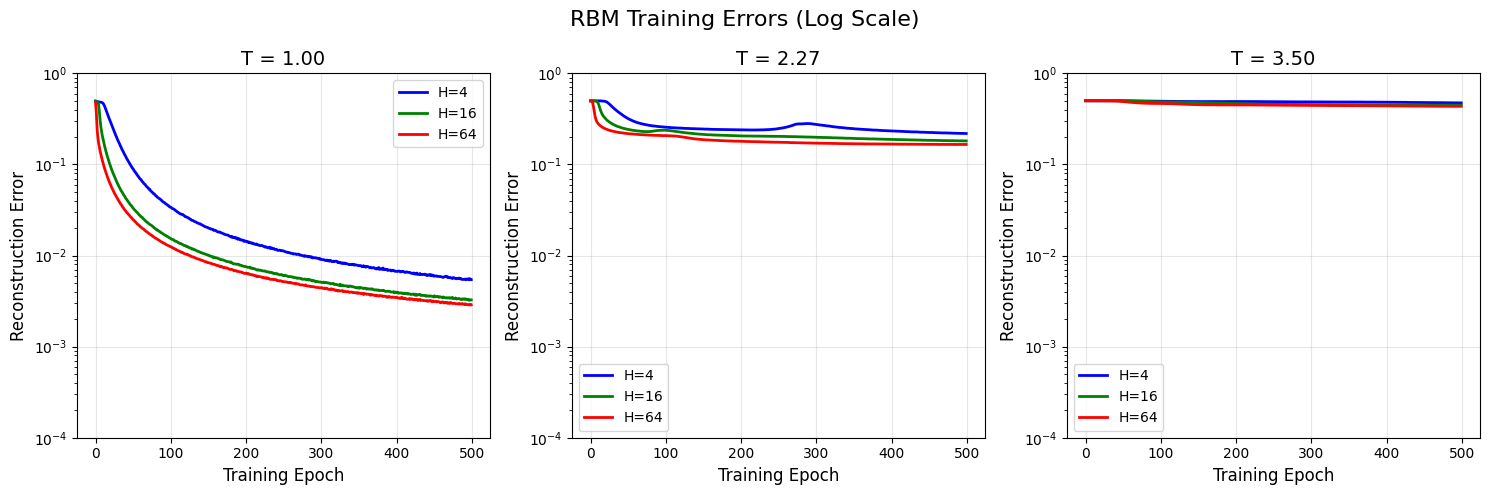


=== DEBUG: Observable Values ===
   Temperature  Hidden_Units  Energy_per_Spin  Magnetization_per_Spin  \
0         1.00            16        -1.951954                0.987921   
1         1.00             4        -1.929137                0.982127   
2         1.00            64        -1.956149                0.988976   
3         2.27            16        -1.232701                0.705445   
4         2.27             4        -0.930534                0.679029   
5         2.27            64        -1.411334                0.767458   
6         3.50            16        -0.465554                0.238100   
7         3.50             4        -0.210789                0.202113   
8         3.50            64        -0.574902                0.241059   

   Specific_Heat_per_Spin        Source  
0                0.375336  RBM_DirectML  
1                0.553024  RBM_DirectML  
2                0.342423  RBM_DirectML  
3                1.941186  RBM_DirectML  
4                1.063300

C:\Users\Khanjan\AppData\Local\Temp\ipykernel_17316\2714988390.py:62: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(h_data['Temperature'], h_data[obs],



Plot saved to: rbm_observables_vs_temperature.png


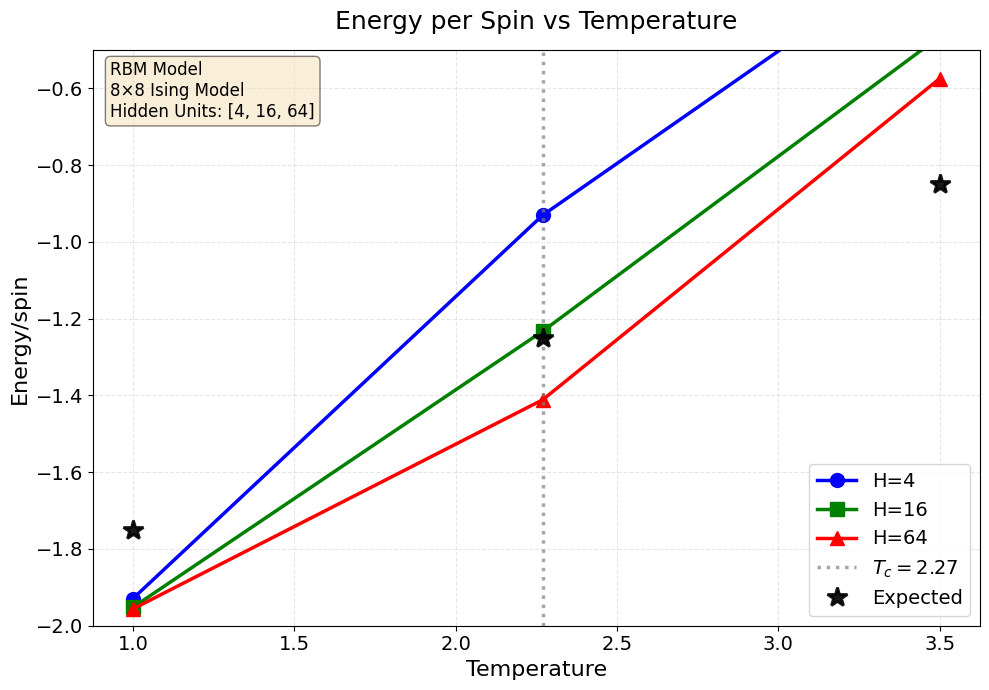

  Individual plot saved: rbm_energy_per_spin_vs_temperature.png


  Individual plot saved: rbm_specific_heat_per_spin_vs_temperature.png


  Individual plot saved: rbm_magnetization_per_spin_vs_temperature.png

Analysis Complete!
MCMC data: ./mcmc_data_directml/
RBM models: ./rbm_models_directml/
RBM samples: ./rbm_samples_directml/
Results: ./rbm_analysis_results_directml.csv


In [27]:
# Step 4: Create plots
print("\nStep 4: Generating plots")
plot_training_errors_debug()
plot_observables_vs_temperature()
    
print("\n" + "="*60)
print("Analysis Complete!")
print(f"MCMC data: ./mcmc_data_directml/")
print(f"RBM models: ./rbm_models_directml/")
print(f"RBM samples: ./rbm_samples_directml/")
print(f"Results: ./rbm_analysis_results_directml.csv")
print("="*60)

In [22]:
# ==================== EXECUTION CODE ====================
print("\n" + "="*70)
print("PIXELCNN IMPLEMENTATION")
print("="*70)

# Step 5: Train PixelCNN models
# Fast training - FIXED: This now uses the function defined above
pixelcnn_models_fast = train_pixelcnn_on_temperatures_fast(data_paths)

# Analyze PixelCNN performance
pixelcnn_results_fast = analyze_pixelcnn_performance_fast(pixelcnn_models_fast)

# Optional: Compare with original RBM results
print("\n" + "="*70)
print("COMPARISON WITH RBM RESULTS")
print("="*70)

# Load RBM results if they exist
if os.path.exists('rbm_analysis_results_directml.csv'):
    rbm_results = pd.read_csv('rbm_analysis_results_directml.csv')
    print("RBM Results:")
    print(rbm_results[['Temperature', 'Hidden_Units', 'Energy_per_Spin', 'Specific_Heat_per_Spin']])
    print("\nPixelCNN Results:")
    print(pixelcnn_results_fast[['Temperature', 'Hidden_Dim', 'Energy_per_Spin', 'Specific_Heat_per_Spin']])
else:
    print("RBM results not found. Run RBM analysis first.")


PIXELCNN IMPLEMENTATION

Training PixelCNN on T = 1.00
  Hidden dim: 32
Training PixelCNN on privateuseone:0
  Samples: 50000, Batch size: 512, Epochs: 30
  Epoch 10: Loss = 0.024930, LR = 0.001500
  Epoch 20: Loss = 0.013791, LR = 0.000500
  Epoch 30: Loss = 0.013761, LR = 0.000000
    Final loss: 0.013761
  Hidden dim: 64
Training PixelCNN on privateuseone:0
  Samples: 50000, Batch size: 512, Epochs: 30
  Epoch 10: Loss = 0.024499, LR = 0.001500
  Epoch 20: Loss = 0.013754, LR = 0.000500
  Epoch 30: Loss = 0.013716, LR = 0.000000
    Final loss: 0.013716

Training PixelCNN on T = 2.27
  Hidden dim: 32
Training PixelCNN on privateuseone:0
  Samples: 50000, Batch size: 512, Epochs: 30
  Epoch 10: Loss = 0.288423, LR = 0.001500
  Epoch 20: Loss = 0.286670, LR = 0.000500
  Epoch 30: Loss = 0.286300, LR = 0.000000
    Final loss: 0.286300
  Hidden dim: 64
Training PixelCNN on privateuseone:0
  Samples: 50000, Batch size: 512, Epochs: 30
  Epoch 10: Loss = 0.286743, LR = 0.001500
  Epoch 

Batch generation: 100%|██████████| 79/79 [00:05<00:00, 13.76it/s]


    Energy: -1.6474, C_v: 0.0002
  Hidden dim: 64
Generating 20000 samples with PixelCNN (parallel)...


Batch generation: 100%|██████████| 79/79 [00:09<00:00,  8.27it/s]


    Energy: -1.6486, C_v: 0.0002

Temperature T = 2.27
  Hidden dim: 32
Generating 20000 samples with PixelCNN (parallel)...


Batch generation: 100%|██████████| 79/79 [00:05<00:00, 13.86it/s]


    Energy: -1.3651, C_v: 0.0002
  Hidden dim: 64
Generating 20000 samples with PixelCNN (parallel)...


Batch generation: 100%|██████████| 79/79 [00:09<00:00,  8.32it/s]


    Energy: -1.3607, C_v: 0.0002

Temperature T = 3.50
  Hidden dim: 32
Generating 20000 samples with PixelCNN (parallel)...


Batch generation: 100%|██████████| 79/79 [00:05<00:00, 13.64it/s]


    Energy: -1.2109, C_v: 0.0001
  Hidden dim: 64
Generating 20000 samples with PixelCNN (parallel)...


Batch generation: 100%|██████████| 79/79 [00:09<00:00,  8.30it/s]

    Energy: -1.2139, C_v: 0.0001

COMPARISON WITH RBM RESULTS
RBM Results:
   Temperature  Hidden_Units  Energy_per_Spin  Specific_Heat_per_Spin
0         1.00            16        -1.951954                0.375336
1         1.00             4        -1.929137                0.553024
2         1.00            64        -1.956149                0.342423
3         2.27            16        -1.232701                1.941186
4         2.27             4        -0.930534                1.063300
5         2.27            64        -1.411334                1.294400
6         3.50            16        -0.465554                0.269157
7         3.50             4        -0.210789                0.246313
8         3.50            64        -0.574902                0.288661

PixelCNN Results:
   Temperature  Hidden_Dim  Energy_per_Spin  Specific_Heat_per_Spin
0         1.00          32        -1.647391                0.000195
1         1.00          64        -1.648638                0.000187
2 


=== RBM vs PixelCNN Comparison ===
RBM samples: 9
PixelCNN samples: 6

Common temperatures: [np.float64(1.0), np.float64(2.27), np.float64(3.5)]
RBM best hidden units: 64
PixelCNN best hidden dim: 64


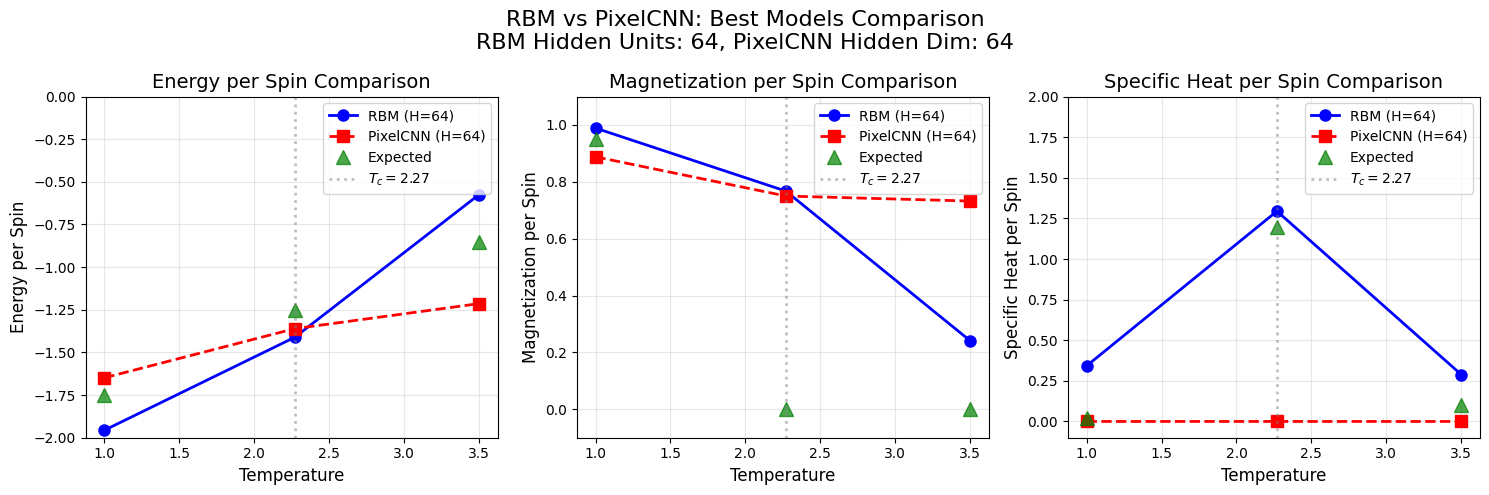


Comparison plot saved to: rbm_pixelcnn_comparison_best.png

=== Detailed Comparison ===

Numerical Comparison:
 Temperature  RBM_Energy  PixelCNN_Energy  Energy_Diff  RBM_Mag  PixelCNN_Mag  Mag_Diff  RBM_Cv  PixelCNN_Cv  Cv_Diff
        1.00     -1.9561          -1.6486       0.3075   0.9890        0.8880    0.1010  0.3424       0.0002   0.3422
        2.27     -1.4113          -1.3607       0.0506   0.7675        0.7501    0.0174  1.2944       0.0002   1.2942
        3.50     -0.5749          -1.2139       0.6390   0.2411        0.7324    0.4913  0.2887       0.0001   0.2886

Detailed comparison saved to: rbm_pixelcnn_detailed_comparison.csv

=== Summary Statistics ===
Mean Energy Difference: 0.332387
Mean Magnetization Difference: 0.203236
Mean Specific Heat Difference: 0.641667

=== Critical Temperature (T=2.27) Comparison ===
RBM Energy: -1.4113
PixelCNN Energy: -1.3607
RBM Magnetization: 0.7675
PixelCNN Magnetization: 0.7501
RBM Specific Heat: 1.2944
PixelCNN Specific Heat: 0.000

In [24]:
# Simple usage with default file names
results = plot_rbm_pixelcnn_comparison()